# Continuation of an equilibrium solution

2025-11-04. Continue an ODE equilibrium solution using BifurcationKit, compare to DNS

## 0. Preliminaries

In [1]:
using LinearAlgebra, Polynomials, Plots, DelimitedFiles, BenchmarkTools, Revise
import BifurcationKit as BK

using CloudAtlas

display("text/html", "<style>.container { width:100% !important; }</style>")

"""
    myreaddlm(filename, cc='%')

Read matrix or vector from a file, dropping comments marked with cc.
"""
function myreaddlm(filename; cc='%')
    X = readdlm(filename, comments=true, comment_char=cc)
    if size(X,2) == 1
        X = X[:,1]
    end
    X
end

# handy symmetry definitions
id = Symmetry()
sx = Symmetry(-1,1,1)
sy = Symmetry(1,-1,1)
sz = Symmetry(1,1,-1)
tx = Symmetry(1,1,1, 1//2, 0//1)
tz = Symmetry(1,1,1, 0//1, 1//2)

pwd()

"/home/gibson/gitworking/CloudAtlas/notebooks"

## 1. Construct ODE model, find equilibrium solution.

This repeats some code from notebook `find-ode-eqb.ipynb`.

In [2]:
α, γ = 1.0, 2.0                     # Fourier wavenumbers α, γ = 2π/Lx, 2π/Lz
J,K,L = 1,2,3                       # Bounds on Fourier modes (J,K) and wall-normal polynomials (L)

H = [sx*sy*sz, sz*tx*tz]            # Generators of the symmetric subspace of the Nagata eqb

@time ijkl = basisIndices(J,K,L, H) # Compute index set of H-symmetric basis elements Ψijkl
@time Ψ = basisSet(α, γ, ijkl)      # Compute basis elements Ψijkl in the index set
@time f, Df = ODEModel(Ψ);          # Do Galerkin projection, return f(x,R) for ODE dx/dt = f(x,R)

@show Nmodes = length(Ψ)

  0.749576 seconds (1.51 M allocations: 71.348 MiB, 99.99% compilation time)
  1.764978 seconds (3.11 M allocations: 151.865 MiB, 1.89% gc time, 99.92% compilation time)
Making matrices B,A1,A2,S3...
Making quadratic operator N...
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 
  2.053778 seconds (3.15 M allocations: 139.050 MiB, 2.51% gc time, 94.93% compilation time)
Nmodes = length(Ψ) = 27


27

Load initial guesses for EQ1 (lower branch) and EQ2 (upper branch) from
files. These are computed by projecting DNS solutions onto the basis, using channelflow. 

In [3]:
R = 200

eq1file = "data/xeq1projection-Re$(R)-$J-$K-$L-$(Nmodes)d.asc"
eq2file = "data/xeq2projection-Re$(R)-$J-$K-$L-$(Nmodes)d.asc"

@show eq1file
@show eq2file

xeq1guess = myreaddlm(eq1file)
xeq2guess = myreaddlm(eq2file)

@show norm(f(xeq1guess, R))
@show norm(f(xeq2guess, R))

eq1file = "data/xeq1projection-Re200-1-2-3-27d.asc"
eq2file = "data/xeq2projection-Re200-1-2-3-27d.asc"
norm(f(xeq1guess, R)) = 0.009524056134927641
norm(f(xeq2guess, R)) = 0.013450208698760794


0.013450208698760794

Find the ODE representations of the lower and upper branch solutions.

In [4]:
fᵣ = x -> f(x,R)    # define function fᵣ(x) = f(x,R)   for fixed R
Dfᵣ = x -> Df(x,R)  # define function Dfᵣ(x) = Df(x,R) for fixed R

@time xeq1, eq1success = hookstepsolve(fᵣ, Dfᵣ, xeq1guess)
@time xeq2, eq2success = hookstepsolve(fᵣ, Dfᵣ, xeq2guess, Nnewton=40)

@show norm(fᵣ(xeq1))/norm(xeq1)
@show norm(fᵣ(xeq2))/norm(xeq2)
@show norm(xeq1)
@show norm(xeq2)
@show eq1success, eq2success;

  1.380145 seconds (2.19 M allocations: 104.981 MiB, 2.34% gc time, 99.54% compilation time)
  0.018593 seconds (168.97 k allocations: 4.328 MiB, 59.20% compilation time)
norm(fᵣ(xeq1)) / norm(xeq1) = 3.3292830176290106e-9
norm(fᵣ(xeq2)) / norm(xeq2) = 2.3423147452653036e-9
norm(xeq1) = 0.417879475377602
norm(xeq2) = 0.4124617816394704
(eq1success, eq2success) = (true, true)


## 2. Continuation of eqbs with BifurcationKit

Define function `shear(x)` for the observable in continuation diagrams

In [5]:
shearΨ = fill(0.0, Nmodes)
for i=1:Nmodes    
    if Ψ[i].u[1].ejx.waveindex == 0 && Ψ[i].u[1].ekz.waveindex == 0
        dΨudy = yderivative(Ψ[i].u[1])
        shearΨ[i] = Ψ[i].u[1].coeff*(dΨudy.p(1.0)  + dΨudy.p(-1.0))/2
    end
end
    
shear(x) = dot(shearΨ, x) + 1.0

shear (generic function with 1 method)

In [6]:
@show shear(xeq1)
@show shear(xeq2)

shear(xeq1) = 1.6460526493761098
shear(xeq2) = 1.9384496404308802


1.9384496404308802

Compute bifurcation diagram from xeq1 solution.

(J, K, L, Nmodes, R) = (1, 2, 3, 27, 200)


┌ Error: Failure to converge with given tolerance = 1.0e-8.
│ Step = 32
│ You can decrease the tolerance or pass a different norm using the argument `normC`.
│ We reached the smallest value [dsmin] valid for ds, namely 0.0001.
│ Stopping continuation at continuation step 32.
└ @ BifurcationKit ~/.julia/packages/BifurcationKit/PnL7a/src/continuation/Contbase.jl:67


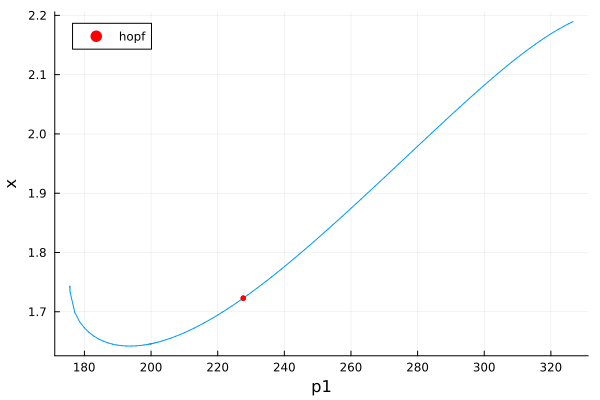

In [7]:
@show J, K, L, Nmodes, R

fbk(x,p) = f(x,p[1])
prob1 = BK.BifurcationProblem(fbk,
        xeq1,         # initial condition x0
        [Float64(R)], # set of parameters
        1;            # parameter index for continuation
        #record_from_solution = (x,p; k...) -> shear(x),
        plot_solution = (x,p; k...) -> shear(x),
        record_from_solution = (x,p; k...) -> shear(x),
    )
newtopts = BK.NewtonPar(1e-08, 25, false, BK.DefaultLS(), BK.DefaultEig(), false, 1.0, 0.01)
contopts = BK.ContinuationPar(p_min = 100., p_max = 400., dsmax = 1.0, max_steps = 100, newton_options = newtopts)

br1 = BK.continuation(prob1, BK.PALC(), contopts, bothside=true)
#br1 = BK.continuation(prob1, BK.PALC(), contopts, bothside=true; finalise_solution = (x, p, step, contResult; k...) -> mySave(x, p, step, contResult, X))
plot(br1)

Compute bifurcation diagram from xeq2 solution. For some reason BifurcationKit doesn't go around the saddle-node bifurcation. I need to learn how to tune the algorithm.

(J, K, L, Nmodes, R) = (1, 2, 3, 27, 200)


┌ Error: Failure to converge with given tolerance = 1.0e-8.
│ Step = 33
│ You can decrease the tolerance or pass a different norm using the argument `normC`.
│ We reached the smallest value [dsmin] valid for ds, namely 0.0001.
│ Stopping continuation at continuation step 33.
└ @ BifurcationKit ~/.julia/packages/BifurcationKit/PnL7a/src/continuation/Contbase.jl:67


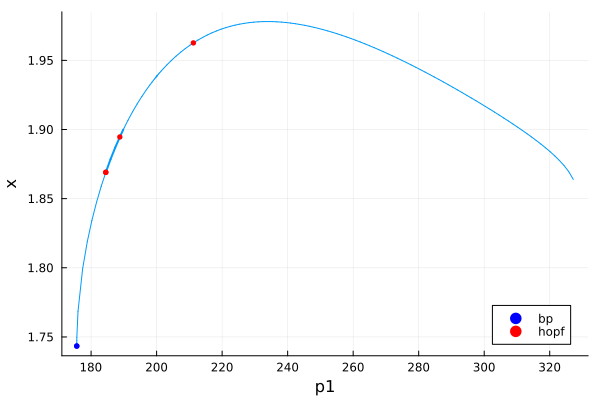

In [8]:
@show J, K, L, Nmodes, R

fbk(x,p) = f(x,p[1])
prob2 = BK.BifurcationProblem(fbk,
        xeq2,         # initial condition x0
        [Float64(R)], # set of parameters
        1;            # parameter index for continuation
        #record_from_solution = (x,p; k...) -> shear(x),
        plot_solution = (x,p; k...) -> shear(x),
        record_from_solution = (x,p; k...) -> shear(x),
    )
newtopts = BK.NewtonPar(1e-08, 25, false, BK.DefaultLS(), BK.DefaultEig(), false, 1.0, 0.01)
contopts = BK.ContinuationPar(p_min = 100., p_max = 400., dsmax = 1.0, max_steps = 100, newton_options = newtopts)

br2 = BK.continuation(prob2, BK.PALC(), contopts, bothside=true)
#br1 = BK.continuation(prob1, BK.PALC(), contopts, bothside=true; finalise_solution = (x, p, step, contResult; k...) -> mySave(x, p, step, contResult, X))
plot(br2)

Plot the ODE bifurcation diagram along with the DNS.

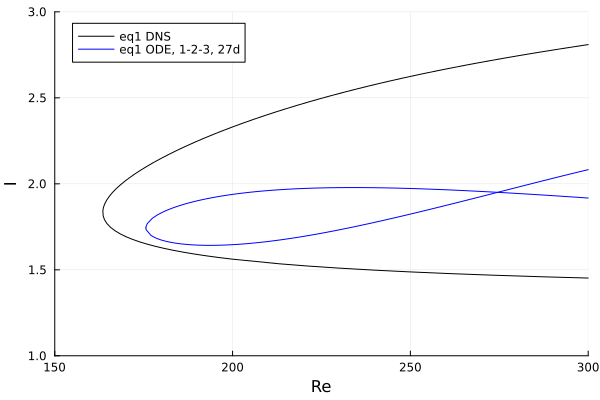

In [9]:
ReD1 = [br1.param br1.x];
ReD2 = [br2.param br2.x];

eq1ReD = myreaddlm("data/eq1ReD-DNS.asc", cc='#')
plot(eq1ReD[:,1], eq1ReD[:,2], color=:black, label="eq1 DNS")
plot!(ReD1[:,1], ReD1[:,2], color=:blue, label="eq1 ODE, $J-$K-$L, $(Nmodes)d")
plot!(ReD2[:,1], ReD2[:,2], color=:blue, label="")
plot!(xlabel="Re", ylabel="I", xlim=(150,300), ylim=(1,3))